<a href="https://colab.research.google.com/github/JstnClmnt/NLP-Text-Summarization/blob/master/NLP_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstractive Text Summarization Using Encoder-Decoder Architecture



## Data Preprocessing

### Import Libraries



In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import re
np.random.seed(1)

### Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Fetch Data





In [0]:
!unzip "/content/drive/Team Drives/AI Lords/NLP-Text-Summarization/dataset.zip"

Archive:  /content/drive/Team Drives/AI Lords/NLP-Text-Summarization/dataset.zip
   creating: data/
   creating: data/business/
  inflating: data/business/001.txt   
  inflating: data/business/002.txt   
  inflating: data/business/003.txt   
  inflating: data/business/004.txt   
  inflating: data/business/005.txt   
  inflating: data/business/006.txt   
  inflating: data/business/007.txt   
  inflating: data/business/008.txt   
  inflating: data/business/009.txt   
  inflating: data/business/010.txt   
  inflating: data/business/011.txt   
  inflating: data/business/012.txt   
  inflating: data/business/013.txt   
  inflating: data/business/014.txt   
  inflating: data/business/015.txt   
  inflating: data/business/016.txt   
  inflating: data/business/017.txt   
  inflating: data/business/018.txt   
  inflating: data/business/019.txt   
  inflating: data/business/020.txt   
  inflating: data/business/021.txt   
  inflating: data/business/022.txt   
  inflating: data/business/023.txt  

In [0]:
import os
 
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = dirName+"/"+entry
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles        

### Load Data to Dataframe

In [0]:
import pandas as pd


dirName = 'data';
    
# Get the list of all files in directory tree at given path
listOfFiles = getListOfFiles(dirName)
    

df=pd.DataFrame(columns=["Title","Description","Category"])
# Print the files    
for elem in listOfFiles:
    print("Reading: "+elem)
    file1 = open(elem,"r",encoding="latin-1") 
    sampleNews=file1.read().split("\n")
    newsDesc=""
    for strline in sampleNews[1:len(sampleNews)]:
        newsDesc+=strline
    """
    print("Category: "+elem.split("/")[1])
    print("Title:"+sampleNews[0])
    print("Description:"+newsDesc[0:50])
    """
    dfsample=pd.DataFrame(columns=["Title","Description","Category"],data=[[sampleNews[0],newsDesc,elem.split("/")[1]]])
    df=df.append(dfsample)

Reading: data/entertainment/331.txt
Reading: data/entertainment/304.txt
Reading: data/entertainment/281.txt
Reading: data/entertainment/344.txt
Reading: data/entertainment/141.txt
Reading: data/entertainment/176.txt
Reading: data/entertainment/212.txt
Reading: data/entertainment/001.txt
Reading: data/entertainment/236.txt
Reading: data/entertainment/002.txt
Reading: data/entertainment/104.txt
Reading: data/entertainment/088.txt
Reading: data/entertainment/376.txt
Reading: data/entertainment/022.txt
Reading: data/entertainment/202.txt
Reading: data/entertainment/111.txt
Reading: data/entertainment/107.txt
Reading: data/entertainment/131.txt
Reading: data/entertainment/372.txt
Reading: data/entertainment/143.txt
Reading: data/entertainment/114.txt
Reading: data/entertainment/060.txt
Reading: data/entertainment/323.txt
Reading: data/entertainment/004.txt
Reading: data/entertainment/110.txt
Reading: data/entertainment/277.txt
Reading: data/entertainment/064.txt
Reading: data/entertainment/

In [0]:
df=df.reset_index()
df=df.drop(list(df)[0], axis=1)
df["Description"].head()[0]

"Russian drama The Return (Vozvrashchenie) has been named winner of the BBC Four World Cinema Award.The film tells the story of two adolescent boys who are subjected to a harsh regime when their strict father returns after a 10-year absence. Directed by Andrey Zvyagintsev, The Return previously won the 2003 Golden Lion award at the Venice Film Festival. The prize was presented at an awards ceremony held in London on Thursday and hosted by Jonathan Ross. The winner was chosen by a panel which included X Files actress Gillian Anderson, critic Roger Clarke and Touching the Void director Kevin McDonald.Ross, who is the presenter of BBC One's Film 2005, was also involved in the deliberations. A shortlist of six films from around the world had been drawn up from which the panel chose. Other nominees included the Motorcycle Diaries, Zatoichi and Hero. A viewer poll saw director Zhang Yimou's martial arts epic Hero emerge as the favourite with 32% of votes cast. Tragedy struck the production o

In [0]:
df=df[["Title","Description"]]
df.head()

,Title,Description
0,Russian film wins BBC world prize,Russian drama The Return (Vozvrashchenie) has ...
1,Fantasy book wins Hollywood deal,A British author has had the film rights to he...
2,Church urges Nelly show boycott,Church ministers are trying to prevent rapper ...
3,Ray Charles studio becomes museum,A museum dedicated to the career of the late l...
4,Police praise 'courageous' Ozzy,Rock star Ozzy Osbourne has been praised by po...


### Clean the Data

This part replaces special characters with spaces and removes null values.

In [0]:
df['Title'] = df['Title'].str.replace("[^a-zA-Z#]"," ")
df['Description'] = df['Description'].str.replace("[^a-zA-Z#]"," ")
df=df.dropna()

In [0]:
from keras.preprocessing.text import Tokenizer
VOCAB_SIZE = 20000
tokenizer = Tokenizer(oov_token=1,num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(df["Description"])
article_sequences = tokenizer.texts_to_sequences(df["Description"])
art_word_index = tokenizer.word_index
len(art_word_index)


Using TensorFlow backend.


27918

In [0]:
art_word_index_1500 = {}
counter = 0
for word in art_word_index.keys():
    if art_word_index[word] == 0:
        print("found 0!")
        break
    if art_word_index[word] > VOCAB_SIZE:
        continue
    else:
        art_word_index_1500[word] = art_word_index[word]
        counter += 1
print(counter)


20000


In [0]:
tokenizer.fit_on_texts(df["Title"])
summary_sequences = tokenizer.texts_to_sequences(df["Title"])
sum_word_index = tokenizer.word_index
len(sum_word_index)

28062

In [0]:
sum_word_index_1500 = {}
counter = 0
for word in sum_word_index.keys():
    if sum_word_index[word] == 0:
        print("found 0!")
        break
    if sum_word_index[word] > VOCAB_SIZE:
        continue
    else:
        sum_word_index_1500[word] = sum_word_index[word]
        counter += 1
print(counter)


20000


### Split into Train and Test Set



In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(article_sequences, summary_sequences, test_size=0.20, random_state=42)

print(X_train[0])

[205, 711, 666, 346, 993, 19, 749, 203, 8, 155, 3841, 4, 5899, 5109, 5, 2821, 22, 2, 872, 2, 322, 1986, 13, 2, 1206, 4, 166, 3841, 10, 3, 17, 113, 51, 7, 203, 2, 71, 50, 5, 50, 226, 3163, 92, 168, 560, 1588, 22, 2, 872, 10, 60, 54, 228, 4856, 5, 30, 221, 3, 154, 6, 369, 41, 5109, 175, 11744, 8060, 10136, 12, 8, 928, 3, 6735, 67, 62, 1899, 68, 933, 172, 2, 222, 484, 993, 15, 684, 7, 6, 7362, 8995, 18, 203, 8, 6209, 1064, 339, 34, 42, 2, 449, 37, 1751, 1146, 13, 1064, 8, 473, 16, 37, 8072, 6, 3392, 7, 2, 2855, 4, 31, 1845, 3, 994, 2, 711, 50, 5, 50, 1667, 5, 2, 449, 887, 1736, 1511, 4, 3501, 4, 166, 10174, 2, 86, 69, 62, 165, 166, 3841, 470, 3167, 58, 16086, 10, 67, 52, 10, 6, 1039, 20, 3, 36, 51, 10, 263, 59, 2, 73, 16, 751, 1897, 484, 21, 3, 1286, 41, 857, 2, 80, 40, 897, 19, 3, 17, 13, 91, 2, 84, 7, 2, 71, 5, 29, 88, 13, 91, 2, 155, 166, 3804, 893, 22, 35, 4308, 3596, 687, 7, 1590, 993, 46, 995, 11, 320, 52, 19, 39, 41, 535, 7, 2, 643, 7, 203, 12, 37, 29, 4302, 10971, 2, 5336, 62, 57,

### Retrieve GloVe

In [0]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2019-05-23 20:19:54--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-05-23 20:19:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  11.7MB/s    in 60s     

2019-05-23 20:20:55 (13.6 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [0]:
!unzip "glove.6B.zip"

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### Word Vectorization


In [0]:
import numpy as np

embeddings_index = dict()
f = open('glove.6B.300d.txt',encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
EMB_DIM=300
num_words=VOCAB_SIZE+1
print("Number of Words:"+str(num_words))

#MAX_LENGTH = len(max(X_train, key=len))
#print("Max Length: "+str(MAX_LENGTH))  # 271

MAX_LENGTH = 500
print("Max Length for Sentences: "+str(MAX_LENGTH))
MAX_LENGTH_SUM = len(max(y_train, key=len))
print("Max Length for Summaries: "+str(MAX_LENGTH_SUM))  # 271

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post',truncating="post")
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post',truncating="post")
train_sentences_Y= pad_sequences(y_train, maxlen=MAX_LENGTH_SUM, padding='post',truncating="post")
test_sentences_Y= pad_sequences(y_test, maxlen=MAX_LENGTH_SUM, padding='post',truncating="post")
#y_train=to_categorical(y_train)
#y_test=to_categorical(y_test)
print(train_sentences_X[0])
print(train_sentences_Y[0])

Number of Words:20001
Max Length for Sentences: 500
Max Length for Summaries: 9
[  205   711   666   346   993    19   749   203     8   155  3841     4
  5899  5109     5  2821    22     2   872     2   322  1986    13     2
  1206     4   166  3841    10     3    17   113    51     7   203     2
    71    50     5    50   226  3163    92   168   560  1588    22     2
   872    10    60    54   228  4856     5    30   221     3   154     6
   369    41  5109   175 11744  8060 10136    12     8   928     3  6735
    67    62  1899    68   933   172     2   222   484   993    15   684
     7     6  7362  8995    18   203     8  6209  1064   339    34    42
     2   449    37  1751  1146    13  1064     8   473    16    37  8072
     6  3392     7     2  2855     4    31  1845     3   994     2   711
    50     5    50  1667     5     2   449   887  1736  1511     4  3501
     4   166 10174     2    86    69    62   165   166  3841   470  3167
    58 16086    10    67    52    10     6  

In [0]:
embedding_matrix_art=np.zeros((num_words,EMB_DIM))
numNoEmb=0
#print(word2index)
for word,i in art_word_index_1500.items():
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_art[i]=embedding_vector
    else:
      numNoEmb+=1
print(numNoEmb)

420


In [0]:
embedding_matrix_sum=np.zeros((num_words,EMB_DIM))
#print(word2index)
numNoEmb=0
for word,i in sum_word_index_1500.items():
    if i>num_words:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_sum[i]=embedding_vector
    else:
      numNoEmb+=1
print(numNoEmb)

416


## Data Modeling

### Creating Seq2Seq Encoder-Decoder

In [0]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import concatenate,Input,Dense, CuDNNLSTM,LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation,Dropout,Add
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import Constant
import numpy as np
from tensorflow.keras.utils import plot_model

HIDDEN_UNITS=512

"""
Chatbot Inspired Encoder-Decoder-seq2seq
"""
'''
encoder_inputs = Input(shape=(MAX_LENGTH, ))
encoder_embedding = Embedding(num_words,EMB_DIM,embeddings_initializer=Constant(embedding_matrix_art),input_length=MAX_LENGTH,trainable=False,mask_zero=True)(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

decoder_inputs = Input(shape=(MAX_LENGTH, ))
decoder_embedding = Embedding(num_words,EMB_DIM,embeddings_initializer=Constant(embedding_matrix_sum),input_length=MAX_LENGTH,trainable=False,mask_zero=True)(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

# dense_layer = Dense(VOCAB_SIZE, activation='softmax')
outputs = TimeDistributed(Dense(num_words, activation='softmax'))(decoder_outputs)
model = tf.keras.Model([encoder_inputs, decoder_inputs], outputs)
'''


"""
Bidirectional LSTM: Others Inspired Encoder-Decoder-seq2seq
"""
encoder_inputs = Input(shape=(MAX_LENGTH,))
encoder_embedding = Embedding(num_words,EMB_DIM,embeddings_initializer=Constant(embedding_matrix_art),input_length=MAX_LENGTH,trainable=False,mask_zero=True)(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

"""
decoder
"""
decoder_inputs = Input(shape=(MAX_LENGTH_SUM,))
decoder_embedding = decoder_embedding = Embedding(num_words,EMB_DIM,embeddings_initializer=Constant(embedding_matrix_sum),input_length=MAX_LENGTH_SUM,trainable=False,mask_zero=True)(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
decoder_dense = TimeDistributed(Dense(num_words, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model= tf.keras.Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)


model.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

print(model.summary())
plot_model(model, to_file='model_seq2seq.png')

TypeError: ignored

In [0]:
num_samples_train = len(train_sentences_Y)
print(num_samples_train)
decoder_output_data_train = np.zeros(shape=(num_samples_train, MAX_LENGTH_SUM, num_words))

1780


In [0]:
num_samples_test = len(test_sentences_Y)
print(num_samples_test)
decoder_output_data_test = np.zeros(shape=(num_samples_test, MAX_LENGTH_SUM, num_words))

445


In [0]:
for i, seqs in enumerate(train_sentences_Y):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data_train[i][j][seq] = 1
            
for i, seqs in enumerate(test_sentences_Y):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data_test[i][j][seq] = 1

### Training the model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='acc', mode='max')
es_acc = EarlyStopping(monitor='acc', mode='max',verbose=1,patience=10,min_delta=0.003)
es_loss = EarlyStopping(monitor='loss', mode='min',patience=10,verbose=1)
history = model.fit([train_sentences_X, train_sentences_Y], 
                     decoder_output_data_train, 
                     epochs=150, 
                     batch_size=32,
                     validation_data=([test_sentences_X, test_sentences_Y], decoder_output_data_test),
                     callbacks=[save,es_acc,es_loss])

Train on 1780 samples, validate on 445 samples
Epoch 1/150
1780/1780 [==============================] - 137s 77ms/sample - loss: 7.2142 - acc: 0.0305 - val_loss: 6.4100 - val_acc: 0.0291
Epoch 2/150
1780/1780 [==============================] - 120s 67ms/sample - loss: 5.9491 - acc: 0.0295 - val_loss: 6.4390 - val_acc: 0.0291
Epoch 3/150
1780/1780 [==============================] - 122s 69ms/sample - loss: 5.8369 - acc: 0.0295 - val_loss: 6.4857 - val_acc: 0.0291
Epoch 4/150
1780/1780 [==============================] - 119s 67ms/sample - loss: 5.7945 - acc: 0.0295 - val_loss: 6.5166 - val_acc: 0.0291
Epoch 5/150
1780/1780 [==============================] - 122s 69ms/sample - loss: 5.7662 - acc: 0.0295 - val_loss: 6.5416 - val_acc: 0.0291
Epoch 6/150
1780/1780 [==============================] - 119s 67ms/sample - loss: 5.7455 - acc: 0.0295 - val_loss: 6.5566 - val_acc: 0.0291
Epoch 7/150
1780/1780 [==============================] - 121s 68ms/sample - loss: 5.7209 - acc: 0.0295 - val_loss

## Model Performance

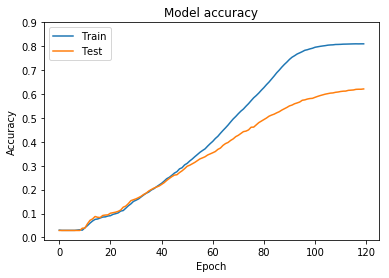

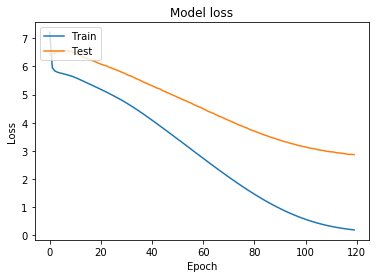

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.yticks(np.arange(0,1,step=0.1))
plt.savefig("acc_lstm.png")

plt.figure( )
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("loss_lstm.png")